# Order parameters

## Graph structure

All edges are stored in a list of sets $edgelist$ such that each of them has a label corresponding to its position. At the same position in the list $X$ are stored the order parameters into a list of $8$ elements. Test: $X$ is now a dictionary

1) ring participation
Two integers: 0 if no ring, number of ring members if a closed ring
(0, 4,5,6,7... 12)

2) Other rings that p1, and p2 are a part of: 1 integer for p1, 1 for p2. Since there is only up to one extra ring per particle

3) number of bonded neighbors of the two particles (p1, p2) involved
Two integers: (1,2,3)

4) Local connectivity parameters
- Average number of bonds per neighbor of p1 and p2. (2 real number)

In [1]:
import numpy as np
#from matplotlib import *
from matplotlib import pyplot as plt
from heapq import *
from collections import deque
from collections import defaultdict
import copy

def adjacencyM(N, E):
    G=np.zeros([N, N])
    for e in E:
        G[int(e[0]), int(e[1])] =1
    return G

def rescale(x, M):
    if x>M/2:
        return rescale(x-M, M)
    elif x<-M/2:
        return rescale(x+M, M)
    else:
        return x
    
def nearestimage(v):
    return [rescale(v[0], xsize), rescale(v[1],ysize) ]
    
        
#G_aM = adjacencyM(N, aev[:,:-1])



In [2]:
l = 0
N=484
C=[]
with open("test.patch", "r") as snap:   #particle positions
    for line in snap:
        if l==0:
            N = int(line[1:])
            l=l+1
        elif l==1:
            tmp=[x for x in line.split()]
            xsize, ysize = float(tmp[0]), float(tmp[1])
            l=l+1
        else:
            tmp=[x for x in line.split()]
            #C.append([rescale(float(tmp[1]), xsize), rescale(float(tmp[2]), ysize)])
            C.append([float(tmp[1]), float(tmp[2])])
            
l = 0
events=[]
with open("breaklist_80.500.dat", "r") as file:  #Breaking Times
    for line in file:
        if l==0:
            l=l+1
        elif l==1:
            tmp=[x for x in line.split()]
            time = float(tmp[-1])
            l=l+1
        else:
            tmp=[x for x in line.split()]
            events.append([int(tmp[0]), int(tmp[1]), float(tmp[3])])

events=np.array(events)
C=np.array(C)

In [12]:
def cleancycle(v):
    f = False
    i=1
    l=len(v)-1
    while not f:
        for j in range(i+1, l):
            if v[j] == v[i]:
                #print("||", i,j,v[i:j])
                v = v[:i] + v[j:]
                break
        l=len(v)-1; #print(v)
        if i == l: f= True
        i += 1
    return v

def bondright(topart, frompart): #next bond if I keep turning right
    ang = []
    for i in G[topart]:
        dr=nearestimage(C[i]-C[topart])
        ang.append([i, np.arctan2(dr[1],dr[0])])
    ang = sorted(ang, key=lambda a: a[1])
    
    if ang[-1][0] == frompart:
        return ang[0][0]
    for i in range(len(ang) -1):
        if ang[i][0] == frompart: 
            return ang[i+1][0]
    return -1

def bondleft(topart, frompart): #next bond if I keep turning left
    ang = []
    for i in G[topart]:
        dr=nearestimage(C[i]-C[topart])
        ang.append([i, np.arctan2(dr[1],dr[0])])
    ang = sorted(ang, key=lambda a: a[1])
    if ang[0][0] == frompart:
        return ang[-1][0]
    for i in range(1, len(ang)):
        if ang[i][0] == frompart: 
            return ang[i-1][0]
    return -1

def cycle(i, j, direction=2):
    loop = [i, j]
    while (loop[-1] != loop[0]):
        if direction == 1: loop.append(bondleft(loop[-1], loop[-2]))
        if direction == 2: loop.append(bondright(loop[-1], loop[-2]))
    loop = cleancycle(loop)
    if len(loop)<4: return (0, -1)
    vex = loop[2] if direction == 1 else loop[-2] #finds the next vertice for the extra rings as dx loops
    return (len(loop), vex)

In [38]:
G=[set() for i in range(N)]
edgelist=deque()
y=[]
#X={}

for evs in events:
    ev = evs[:-1]
    edgelist.append(set(ev))
    #X[frozenset(ev)] = -1*np.ones(8)
    G[int(ev[0])].add(int(ev[1]))
    G[int(ev[1])].add(int(ev[0]))
    y.append(evs[-1])
    
X = np.array([-1*np.ones(8) for i in range(len(edgelist))])
y = time/np.array(y)
m = np.mean(y)
std = np.std(y)
y=(((y-m)/std)+1)/2

In [39]:
for i in range(N):
    avg = 0
    if len(G[i]) == 0: continue
    for j in G[i]:
        e_idx = edgelist.index({i,j}) 
        if X[e_idx][0] == -1:
            X[e_idx][0], p1_2 = cycle(i, j, 1)                                                 #finds left ring

            if X[e_idx][0] != 0:
                X[e_idx][1], p2_end =cycle(i, j, 2)                                            #finds right ring
                X[e_idx][2] = cycle(i, p2_end)[0] if len(G[i]) == 3 else 0
                X[e_idx][3] = cycle(j, p1_2)[0] if len(G[j]) == 3 else 0
            else:
                X[e_idx][1:4] = np.zeros(3)

            X[e_idx][4:6] = np.array([len(G[i]), len(G[j])])
        avg += len(G[j])
        
    avg /= len(G[i])                                                             #finds 3
    
    for j in G[i]:
        idx= 7 if i>j else 6
        X[edgelist.index({i,j})][idx] = avg                                      #finds 4

# Learning parameters

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

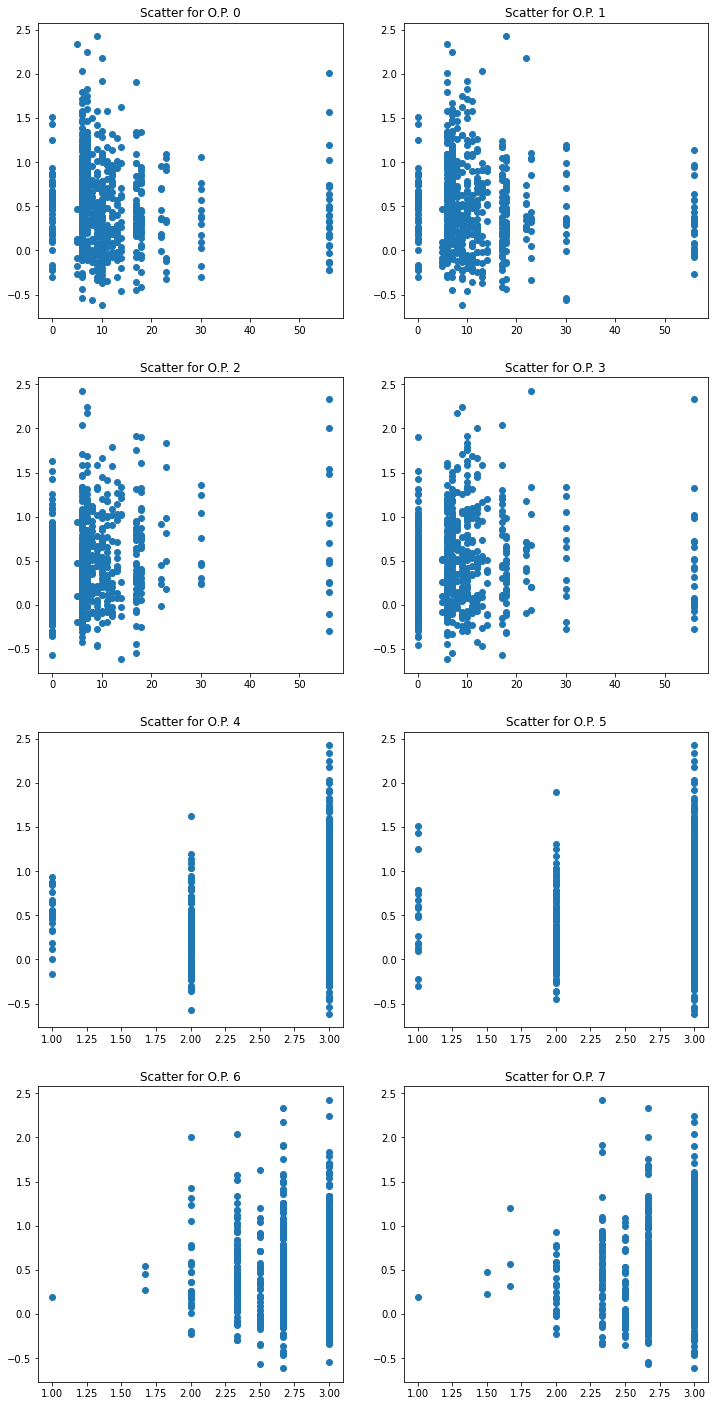

In [41]:
fig, axes = plt.subplots(4, 2, figsize=(12,25))
for i in range(4):
    for j in range(2):
        axes[i][j].set_title("Scatter for O.P. %i"%(2*i+j))
        axes[i][j].scatter(X[:,2*i+j],y)
plt.show()